# Implementing LinUCB For MovieLens 100k Datasaet


### Initialization python envirnment


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
rng = np.random.default_rng()




### Loading the data and define train and test data

In [12]:
item_file = 'ml-100k/u.item'
user_file = 'ml-100k/u.user'
rating_file = 'ml-100k/u.data'


item_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
] + [f'genre_{i}' for i in range(19)]  # 19 genres

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

items = pd.read_csv(item_file, sep='|', encoding='latin-1', names=item_cols, header=None)
users = pd.read_csv(user_file, sep='|', names=user_cols, header=None)

ratings = pd.read_csv(rating_file, sep='\t', names=rating_cols, header=None)

#  sorting ratings by timestamp before splitting to simulate chronological learning:
ratings = ratings.sort_values(by='timestamp')

ix = int(len(ratings) * 0.8)
train = ratings.iloc[0:ix,:].copy()
test = ratings.iloc[ix:,:].copy()


For contextual thompson sampling and LinUCB since we are using a model, we should frist prepare the features as input to the model. We use both user and movie features as input to the model.  

In [13]:

# bins user ages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = range(len(bins)-1)
users['age_bucket'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)
age_ohe = pd.get_dummies(users['age_bucket'], prefix='age')
users = pd.concat([users, age_ohe], axis=1)
# ensure everything is numeric
users[age_ohe.columns] = users[age_ohe.columns].astype(int)




# creates a one-hot encoding for M, F, and any potential missing values.
gender_dummies = pd.get_dummies(users['gender'], prefix='gender')
users = pd.concat([users, gender_dummies], axis=1)


#occupation
occupation_ohe = pd.get_dummies(users['occupation'], prefix='occ')
users = pd.concat([users, occupation_ohe], axis=1)

# ensure everything is numeric
users[occupation_ohe.columns] = users[occupation_ohe.columns].astype(int)



#zip_code
# we apply smooth target encoding, it should be on training data only
train_rating_user = train.merge(users, on='user_id', how='left')
test_rating_user = test.merge(users, on='user_id', how='left')
zip_code_stats = train_rating_user.groupby('zip_code')['rating'].agg(['count', 'mean']).reset_index()
global_mean = np.mean(train['rating'])
m = 20


def apply_smooth_target_encoding(df):
    merged_df = pd.merge(df[['zip_code']], zip_code_stats, on = 'zip_code', how='left')
    merged_df['count'] = merged_df['count'].fillna(0)
    merged_df['mean'] = merged_df['mean'].fillna(global_mean)
    zip_code_encoded = (merged_df['count']*merged_df['mean'] + m * global_mean)/(merged_df['count']+m)

    return zip_code_encoded


train_rating_user['encoded_zip_code'] = apply_smooth_target_encoding(train_rating_user)
test_rating_user['encoded_zip_code'] = apply_smooth_target_encoding(test_rating_user)

############### Adding movie features to context ################

train_rating_user_movie = train_rating_user.merge(items, on='movie_id', how='left')
test_rating_user_movie = test_rating_user.merge(items, on='movie_id', how='left')

# age of movie feature: timestamp - release year

train_rating_user_movie['rating_year'] = pd.to_datetime(train_rating_user_movie['timestamp'], unit='s').dt.year
test_rating_user_movie['rating_year'] = pd.to_datetime(test_rating_user_movie['timestamp'], unit='s').dt.year

train_rating_user_movie['release_year'] = pd.to_datetime(train_rating_user_movie['release_date'], format='%d-%b-%Y').dt.year
test_rating_user_movie['release_year'] = pd.to_datetime(test_rating_user_movie['release_date'], format='%d-%b-%Y').dt.year


train_rating_user_movie['movie_age'] = train_rating_user_movie['rating_year'] - train_rating_user_movie['release_year']
test_rating_user_movie['movie_age'] = test_rating_user_movie['rating_year'] - test_rating_user_movie['release_year']



list_dropped_columns = ['timestamp', 'age', 'gender','occupation','zip_code','age_bucket','title', 'release_date','video_release_date','IMDb_URL','rating_year','release_year']

train_rating_user_movie = train_rating_user_movie.drop(columns = list_dropped_columns)
test_rating_user_movie = test_rating_user_movie.drop(columns = list_dropped_columns)


### Define Arms to be Movie Ids


In [14]:
unique_arms = ratings['movie_id'].unique()


# Linear UCB
In LinUCB the expected reward is linear in context: $E[r_{t,a}] = x_{t,a}^T \theta^*$, where $\theta^*$ is the parameter we learn. In LinUCB we balance exploration and exploitation by selecting arm by:

$$score_{t,a} = x_{t,a}^T \hat{\theta_t} + \alpha \sqrt{x_{t,a}^T A^{-1} x_{t,a}}$$

**Algorithm:**
1. Initialie

    1.1.$A = I_d$ (Identity matrix of size d x d)
    1.2. $b=0_d$ (zero vector of size d)
    
2. Repeat:

    2.1. for each arm get the context $x_{t,a} \in R^d$
    
    2.2. compute $\hat{\theta} = A^{-1} b$
    
    2.3. compute score $score_{t,a} = x_{t,a}^T \hat{\theta_t} + \alpha \sqrt{x_{t,a}^T A^{-1} x_{t,a}}$
    
    2.4. chose arm $a_t = \arg\max_a score_a$
    
    2.5. observe reward $r_t$
    
    2.6. Update parameters: $A = A + x_{t,a} x_{t,a}^T$ and $b = b + r_t x_{t,a}$
    

This formual is directly related to Linear Regression in which $A = X^T X$ and $b = X^T R$

In [15]:
# LinUCB class with Shared Model
class LinUCB:
    def __init__(self, arms, dim, alpha):
        self.arms = arms  # list of movie_ids
        self.dim = dim
        self.lamb = 0.1
        self.A = self.lamb * np.eye(dim) # dim x dim
        self.b = np.zeros(dim) # 1 x dim or (dim,)
        self.alpha = alpha

    def select_arm(self, contexts):
        """
        contexts: np.ndarray of shape (m, dim), row i = context for self.arms[i]
        returns: arm_id
        """
        
        contexts = np.asarray(contexts)
        
        A_inv = np.linalg.solve(self.A, np.eye(self.dim)) 
        
        theta_hat = np.dot(A_inv, self.b)
        
        linear_score = contexts @ theta_hat #(m,dim) @ (dim,) -> (m,)
        
        # The uncertainty term is alpha * sqrt(x_i^T * A_inv * x_i)
        # The diagonal of (X @ A_inv @ X.T) gives us the required term (x_i^T * A_inv * x_i)
#         uncertainty_scores = np.sqrt(np.diag(contexts @ A_inv @ contexts.T))
        
        
        #computed x_i^T A^-1 X_i for all rows at once
        u2 = np.einsum('ij,jk,ik->i', contexts, A_inv, contexts)         # (m,)
        uncertainty_scores = np.sqrt(u2)
        
        # final score
        scores = linear_score + self.alpha * uncertainty_scores

        ix = np.argmax(scores)
        
        return ix
            


    def update(self, context, reward):
        """
        context: np.ndarray shape (dim,) for the arm you just played
        reward:  scalar
        """
        x = np.asarray(context, dtype=float).ravel()
        # guards
        if not np.isfinite(x).all():
            # skip this update OR replace NaNs with 0
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        
        
        self.A += np.outer(x, x) # X^T X accumulation
        self.b += reward * x # X^T y accumulation
        


### Online Training
We simulate online interactions

In [17]:
import numpy as np

# ** Build list of feature columns (everything except ids and target)
# ** Make sure this matches the columns you intend to feed as context
feature_cols = [c for c in train_rating_user_movie.columns 
                if c not in ['user_id', 'movie_id', 'rating']]

# ** Dynamically set dim from feature_cols (avoid hard-coding like 53)
dim = len(feature_cols)

# ** (Optional but recommended) Shuffle user order to reduce ordering bias
unique_users = np.random.permutation(train_rating_user_movie['user_id'].unique())

linucb = LinUCB(unique_arms, dim, alpha = 0.5)

total_interactions = 0
total_rewards = 0

num_interactions_per_user = 3  # we can change this

for user_id in unique_users:
    # ** Work on a copy so we can drop picked rows (avoid re-recommending same row)
    user_rows = train_rating_user_movie[train_rating_user_movie['user_id'] == user_id].copy()

    for _ in range(num_interactions_per_user):
        # ** stop if this user has no remaining candidates
        if user_rows.empty:
            break

        # ** Extract candidate matrix Xcand as float ndarray with shape (m, dim)
        Xcand = user_rows[feature_cols].to_numpy(dtype=float)

        # select index into Xcand
        ix = linucb.select_arm(Xcand)

        # ** Fetch reward from the matched row
        picked_row = user_rows.iloc[ix]
        reward = int(picked_row['rating'] >= 4)

        # ** Get the context vector corresponding to the chosen candidate
        x = Xcand[ix]  # shape (dim,)

        # update posterior
        linucb.update(x, reward)

        total_rewards += reward
        total_interactions += 1

        # ** Remove the picked row so we don't pick it again for this user
        user_rows = user_rows.drop(user_rows.index[ix])

print(f"Total Interactions: {total_interactions}")
print(f"Total Reward (ratings ≥ 4): {total_rewards}")
print(f"Average Reward: {total_rewards / total_interactions:.4f}")


Total Interactions: 2251
Total Reward (ratings ≥ 4): 1616
Average Reward: 0.7179


## Precision@K

In [18]:
k = 5
precisions = []

# pull needed pieces from your LinUCB instance
A = linucb.A
b = linucb.b
alpha = linucb.alpha
d = linucb.dim

# precompute A^{-1} once for this evaluation
A_inv = np.linalg.solve(A, np.eye(d))
theta = A_inv @ b   # exploitation weights

for user in unique_users:
    user_df = test_rating_user_movie[test_rating_user_movie['user_id'] == user].copy()
    
    if user_df.empty:
        continue

    X_user = user_df[feature_cols].to_numpy(dtype=float)

    # ----- Option 1: exploitation-only (recommended for Precision@K) -----
    scores = X_user @ theta

    # ----- Option 2: include UCB bonus (comment Option 1 and uncomment below) -----
    # u2 = np.einsum('ij,jk,ik->i', X_user, A_inv, X_user)   # xᵀ A^{-1} x per row
    # u  = np.sqrt(np.maximum(u2, 0.0))
    # scores = (X_user @ theta) + alpha * u

    top_idx = np.argsort(scores)[-k:][::-1]
    top_movies = user_df.iloc[top_idx]

    hits = (top_movies['rating'] >= 4).sum()
    denom = min(k, len(user_df))   # or use k if you prefer a fixed denominator
    precisions.append(hits / denom)

precision_k = float(np.mean(precisions)) if precisions else 0.0
print(f"Precision@{k}: {precision_k:.4f}")



Precision@5: 0.5216


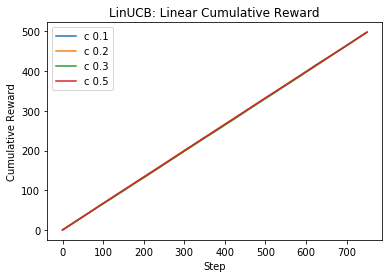

In [15]:
c_values = [0.1,0.2,0.3, 0.5]

num_simulations = 100

for c in c_values:
    
    all_runs = [] # stores cumulative rewards from each simulation
    
    for sim in range(num_simulations):
        
        total_interactions = 0
        total_rewards = 0
        
        num_interactions_per_user = 1  # <--- you can change this number

        linucb = LinUCB(unique_arms, dim, c)

        unique_users = np.random.permutation(train_rating_user_movie['user_id'].unique())
        #unique_users = train['user_id'].unique()
    
        cum_reward =[]
        cur_step = 0
    
        for user_id in unique_users:
            user_rows = train_rating_user_movie[train_rating_user_movie['user_id'] == user_id].copy()

            for _ in range(num_interactions_per_user):

                
                # ** stop if this user has no remaining candidates
                if user_rows.empty:
                    break

                Xcand = user_rows[feature_cols].to_numpy(dtype=float)

                # select index into Xcand
                ix = linucb.select_arm(Xcand)

                # ** Fetch reward from the matched row
                picked_row = user_rows.iloc[ix]
                reward = int(picked_row['rating'] >= 4)

                total_rewards += reward
                total_interactions += 1
                cum_reward.append(total_rewards)
                
        all_runs.append(cum_reward)
        
    ave_cum_reward = np.mean(all_runs, axis=0)        
    plt.plot(ave_cum_reward, label=f'c {c}')



            
            
            

plt.title('LinUCB: Linear Cumulative Reward')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()